In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
df = pd.read_excel('Iniciativas em Construção Sustentável e Circular (Responses).xlsx').drop(['Timestamp', 'Nome', 'Email'], axis=1)

In [27]:
multi_answer_cols = ['Localização NUT III (pode ser selecionada mais do que uma)',
                     'Grupo de stakeholders que pertencem à organização (pode ser selecionada mais do que uma)',
                     'Se tivesse 60 000€ para o desenvolvimento de um novo serviço ou produto relacionado com a reutilização de materiais (excluindo investimentos), como usaria este valor? (Escolha até 3 opções)',
                     'Que barreiras existentes identifica na implementação e no desenvolvimento de um novo produto ou serviço para a reutilização de materiais?  (Escolha até 3 opções)',
                     'Que estratégias de circularidade / reutilização já estão implementadas na sua entidade?  (É possível selecionar mais do que uma opção).',
                     'Que ações internacionais considera necessárias para o desenvolvimento de práticas mais circulares / reutilização? (É possível selecionar mais do que uma opção).',
                     'De forma a desenvolver práticas de circularidade / reutilização na sua entidade, em quais das seguintes opções estaria interessado? (É possível selecionar mais do que uma opção).',
                     'No âmbito do B4PIC, quais das seguintes atividades considera ser mais importante para a sua organização? (É possível selecionar mais do que uma opção).',
                     'Em que tipo de projetos gostaria de participar? (É possível selecionar mais do que uma opção).',
                     'Que indicadores de sustentabilidade poderiam apoiar a sua atividade? (É possível selecionar mais do que uma opção).',
                     ]


# Clean and split responses into lists
for col in multi_answer_cols:
    df[col] = df[col].fillna('').str.split(', ')

In [28]:
tidy_dfs = []

# Loop through each question column (excluding location)
question_cols = multi_answer_cols[1:]  # Skip "Localização NUT III"

for col in question_cols:
    # Subset relevant columns
    temp_df = df[[
        'Nome da Entidade', 
        'Localização NUT III (pode ser selecionada mais do que uma)', 
        col
    ]]
    
    # Explode both Location and Answer columns
    temp_df = temp_df.explode('Localização NUT III (pode ser selecionada mais do que uma)')
    temp_df = temp_df.explode(col)
    
    # Rename and clean
    temp_df = temp_df.rename(columns={col: 'Answer'})
    temp_df['Question'] = col  # Track which question this answer belongs to
    tidy_dfs.append(temp_df)

# Combine all DataFrames
tidy_df = pd.concat(tidy_dfs, ignore_index=True)

# Clean whitespace and drop empty rows
tidy_df['Answer'] = tidy_df['Answer'].str.strip()
tidy_df['Localização NUT III (pode ser selecionada mais do que uma)'] = (
    tidy_df['Localização NUT III (pode ser selecionada mais do que uma)'].str.strip()
)
tidy_df = tidy_df.dropna(subset=['Answer', 'Localização NUT III (pode ser selecionada mais do que uma)'])

In [29]:
tidy_df

,Nome da Entidade,Localização NUT III (pode ser selecionada mais do que uma),Answer,Question
0,NaN,,,Grupo de stakeholders que pertencem à organiza...
1,Faculdade de Engenharia da Universidade do Porto,PT11A Área Metropolitana do Porto,utilizadores de edifícios,Grupo de stakeholders que pertencem à organiza...
2,Faculdade de Engenharia da Universidade do Porto,PT11A Área Metropolitana do Porto,gestores de instalações,Grupo de stakeholders que pertencem à organiza...
3,Faculdade de Engenharia da Universidade do Porto,PT11A Área Metropolitana do Porto,investigadores e academia,Grupo de stakeholders que pertencem à organiza...
4,Conduril Engenharia S.A.,PT11A Área Metropolitana do Porto,empreiteiros e construtores,Grupo de stakeholders que pertencem à organiza...
...,...,...,...,...
1120,CVR-Centro para a Valorização de Resíduos,PT119 Ave,Avaliação do Produto (EPD),Que indicadores de sustentabilidade poderiam a...
1121,CVR-Centro para a Valorização de Resíduos,PT119 Ave,etc.).,Que indicadores de sustentabilidade poderiam a...
1122,BUILTCoLAB,PT11A Área Metropolitana do Porto,Reporte corporativo (exemplo: CSRD).,Que indicadores de sustentabilidade poderiam a...
1123,BUILTCoLAB,PT11A Área Metropolitana do Porto,Avaliação de circularidade (exemplo: Circulytics,Que indicadores de sustentabilidade poderiam a...


In [69]:
tidy_df['Answer'] = tidy_df['Answer'].str.strip()
tidy_df = tidy_df[tidy_df['Answer'] != '']

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3541306777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_df['Answer'] = tidy_df['Answer'].str.strip()


In [70]:
def plot_stacked_percentages(target_question, group_by='Location', 
                            title_suffix='', figsize=(12,8), 
                            palette='viridis'):
    """
    Parameters:
    - target_question: The exact text of the question to analyze
    - group_by: One of ['Location', 'Entity', 'Stakeholders', 'Total']
    - title_suffix: Optional text to add to end of title
    - figsize: Figure dimensions
    - palette: Color palette name
    """
    
    # Base data for target question
    base_df = tidy_df[tidy_df['Question'] == target_question][['Nome da Entidade', 'Answer']]
    
    # Split answers on '(exemplo:' and keep first part
    for i in range(len(base_df)):
        if 'exemplo:' in base_df['Answer'].iloc[i]:
            base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()
  
    
    # Handle different grouping types
    if group_by == 'Location':
        # Get locations with entity names
        locations = df[['Nome da Entidade', 'Localização NUT III (pode ser selecionada mais do que uma)']]
        locations = locations.explode('Localização NUT III (pode ser selecionada mais do que uma)')
        locations['Localização NUT III (pode ser selecionada mais do que uma)'] = locations['Localização NUT III (pode ser selecionada mais do que uma)'].str.strip()
        grouped_df = base_df.merge(locations, on='Nome da Entidade')
        group_col = 'Localização NUT III (pode ser selecionada mais do que uma)'
        
    elif group_by == 'Stakeholders':
        stakeholders = tidy_df[tidy_df['Question'] == 'Grupo de stakeholders que pertencem à organização (pode ser selecionada mais do que uma)']
        stakeholders = stakeholders[['Nome da Entidade', 'Answer']].rename(columns={'Answer': 'Stakeholder'})
        grouped_df = base_df.merge(stakeholders, on='Nome da Entidade')
        group_col = 'Stakeholder'
        
    elif group_by == 'Entity':
        grouped_df = base_df
        group_col = 'Nome da Entidade'
        
    elif group_by == 'Total':
        grouped_df = base_df.copy()
        grouped_df['Total'] = 'Total'
        group_col = 'Total'
        
    else:
        raise ValueError("Invalid group_by. Choose: ['Location', 'Entity', 'Stakeholders', 'Total']")

    # Calculate percentages
    count_data = grouped_df.groupby([group_col, 'Answer']).size().reset_index(name='Count')
    count_data['Total per Group'] = count_data.groupby(group_col)['Count'].transform('sum')
    count_data['Percentage'] = (count_data['Count'] / count_data['Total per Group']) * 100

    # Pivot and sort
    pivot_df = count_data.pivot(index=group_col, columns='Answer', values='Percentage').fillna(0)
    
    # Order by total responses if applicable
    if group_by != 'Total':
        group_order = count_data.groupby(group_col)['Count'].sum().sort_values(ascending=False).index
        pivot_df = pivot_df.reindex(group_order)

    # Plotting
    plt.figure(figsize=figsize)
    ax = pivot_df.plot(kind='barh', stacked=True, cmap=palette, figsize=figsize)

    # Add percentage labels
    for i, (group_name, row) in enumerate(pivot_df.iterrows()):
        cumulative = 0
        for answer, percentage in row.items():
            if percentage > 0:
                x_pos = cumulative + (percentage / 2)
                y_pos = i
                if percentage >= 5:
                    ax.text(x_pos, y_pos, 
                            f'{percentage:.1f}%', 
                            ha='center', va='center',
                            color='white', fontsize=8)
                cumulative += percentage

    plt.title(f'{target_question[:60]}... by {group_by} {title_suffix}'.strip(), pad=20)
    plt.xlabel('Percentage of Responses (%)')
    plt.ylabel(group_by)
    plt.legend(title='Answers', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

<Figure size 1200x800 with 0 Axes>

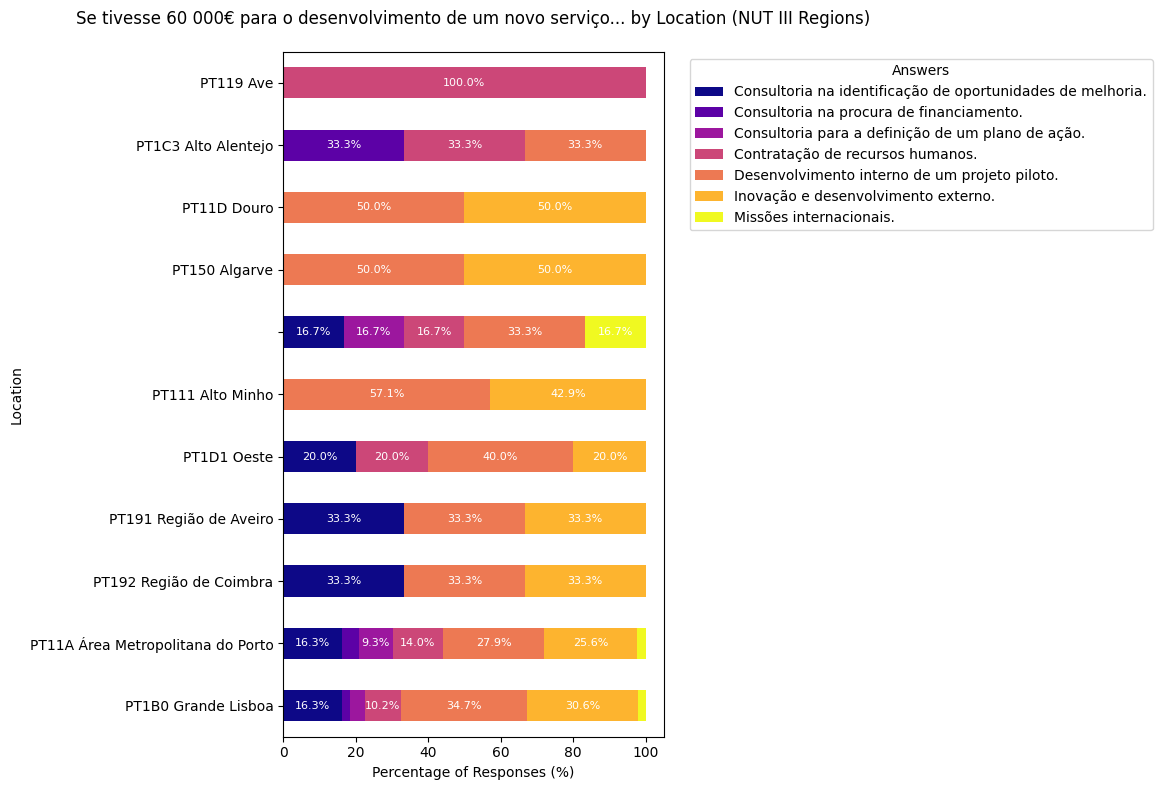

In [71]:
# For location grouping
plot_stacked_percentages(
    target_question='Se tivesse 60 000€ para o desenvolvimento de um novo serviço ou produto relacionado com a reutilização de materiais (excluindo investimentos), como usaria este valor? (Escolha até 3 opções)',
    group_by='Location',
    title_suffix='(NUT III Regions)',
    palette='plasma'
)


<Figure size 1200x800 with 0 Axes>

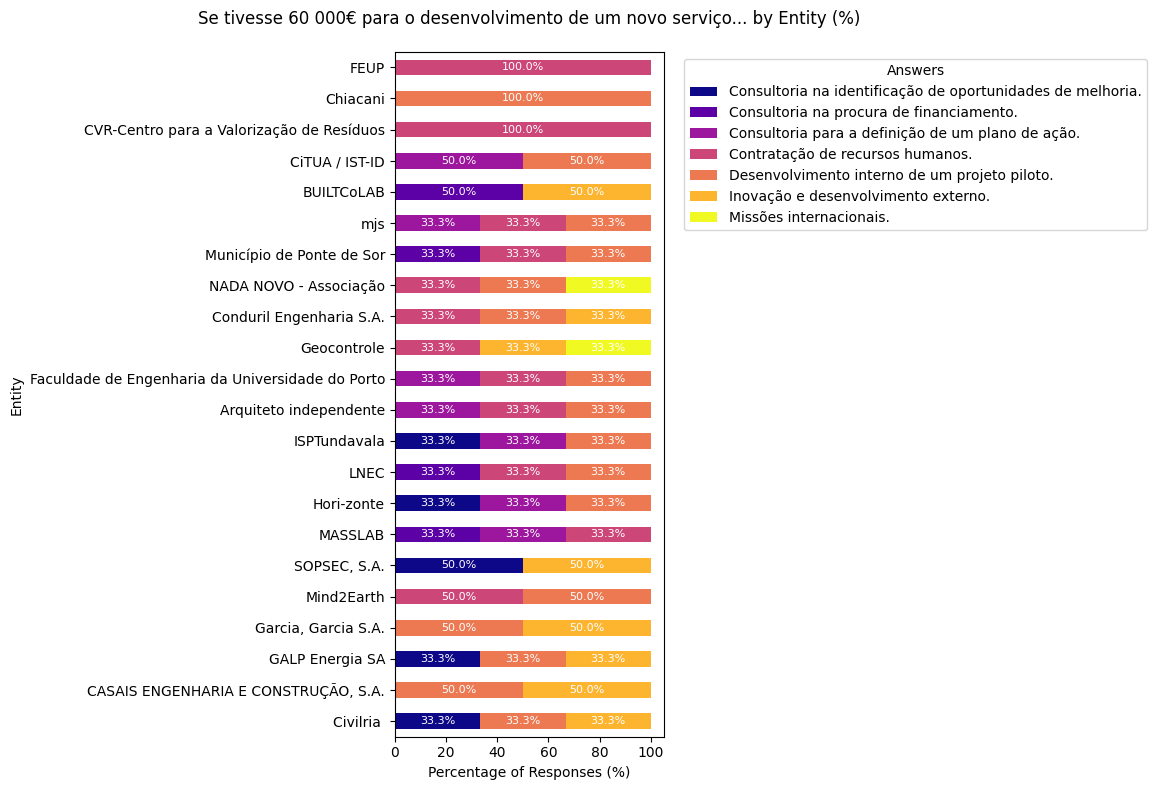

In [72]:
# For location grouping
plot_stacked_percentages(
    target_question='Se tivesse 60 000€ para o desenvolvimento de um novo serviço ou produto relacionado com a reutilização de materiais (excluindo investimentos), como usaria este valor? (Escolha até 3 opções)',
    group_by='Entity',
    title_suffix='(%)',
    palette='plasma'
)

<Figure size 1200x800 with 0 Axes>

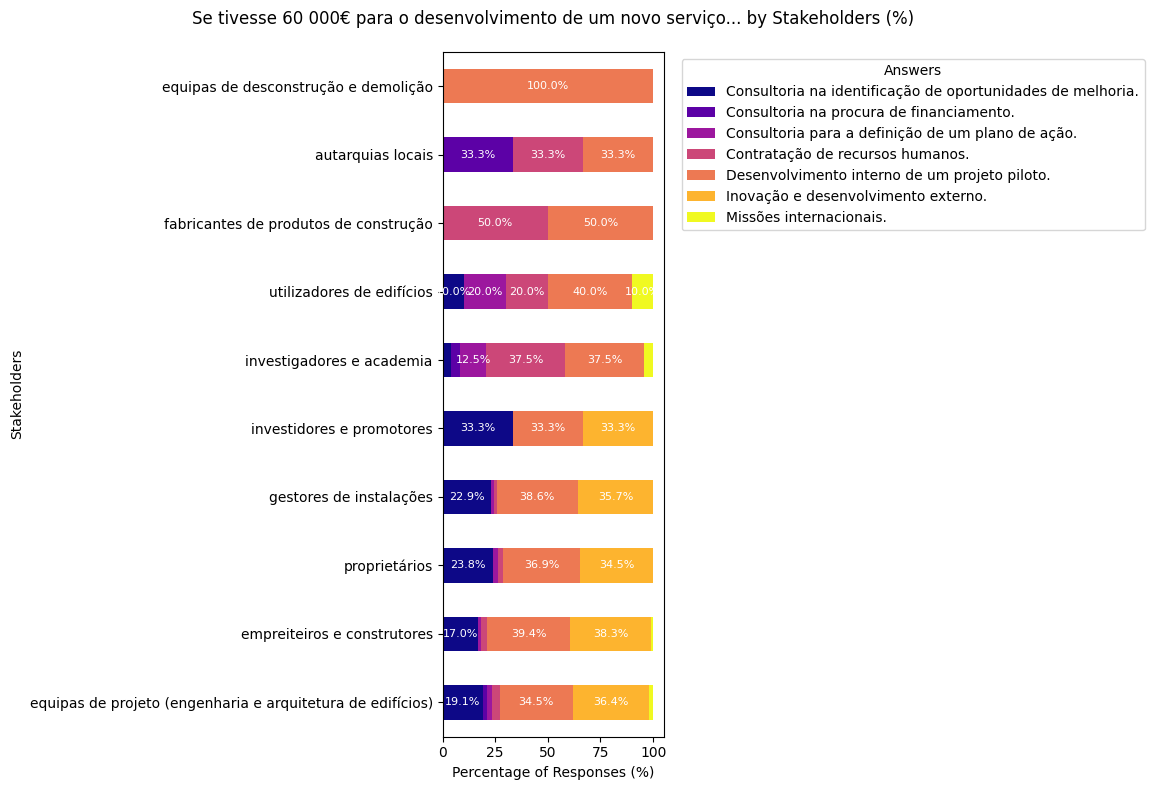

In [73]:
# For location grouping
plot_stacked_percentages(
    target_question='Se tivesse 60 000€ para o desenvolvimento de um novo serviço ou produto relacionado com a reutilização de materiais (excluindo investimentos), como usaria este valor? (Escolha até 3 opções)',
    group_by='Stakeholders',
    title_suffix='(%)',
    palette='plasma'
)

<Figure size 1200x800 with 0 Axes>

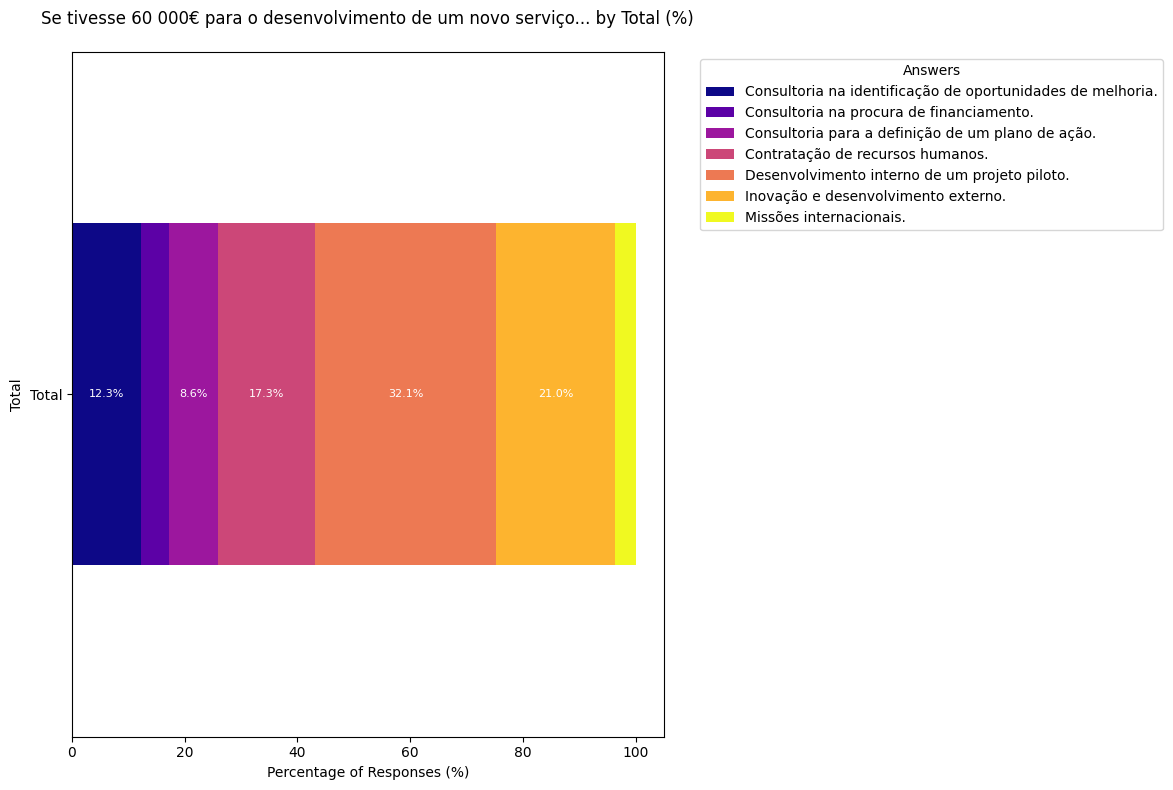

In [74]:
# For location grouping
plot_stacked_percentages(
    target_question='Se tivesse 60 000€ para o desenvolvimento de um novo serviço ou produto relacionado com a reutilização de materiais (excluindo investimentos), como usaria este valor? (Escolha até 3 opções)',
    group_by='Total',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

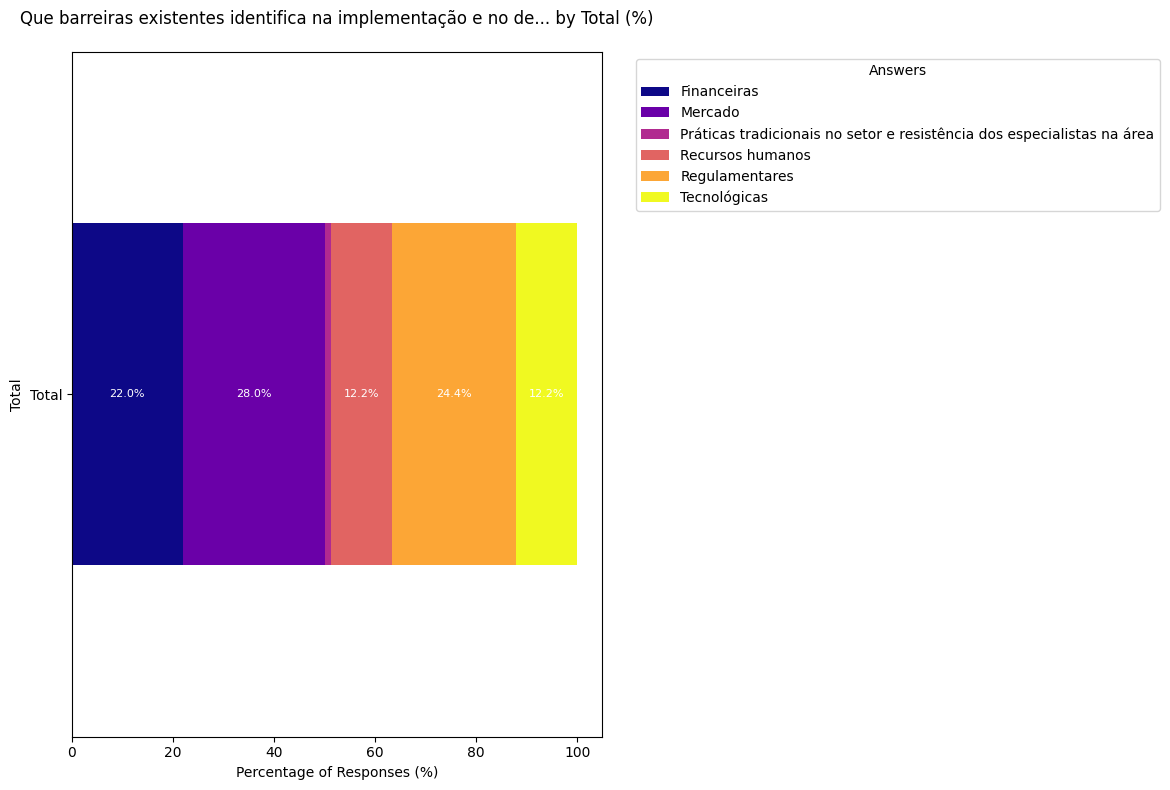

In [75]:
# For location grouping
plot_stacked_percentages(
    target_question='Que barreiras existentes identifica na implementação e no desenvolvimento de um novo produto ou serviço para a reutilização de materiais?  (Escolha até 3 opções)',
    group_by='Total',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

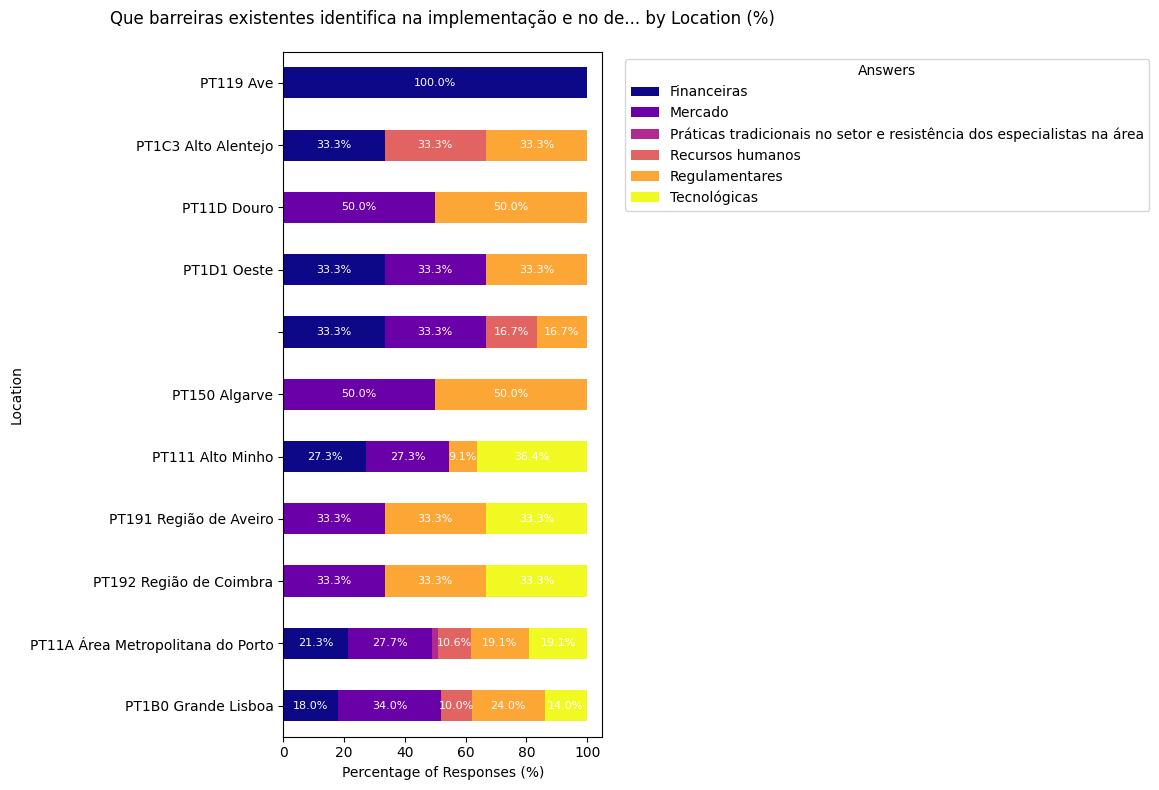

In [91]:
# For location grouping
plot_stacked_percentages(
    target_question='Que barreiras existentes identifica na implementação e no desenvolvimento de um novo produto ou serviço para a reutilização de materiais?  (Escolha até 3 opções)',
    group_by='Location',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

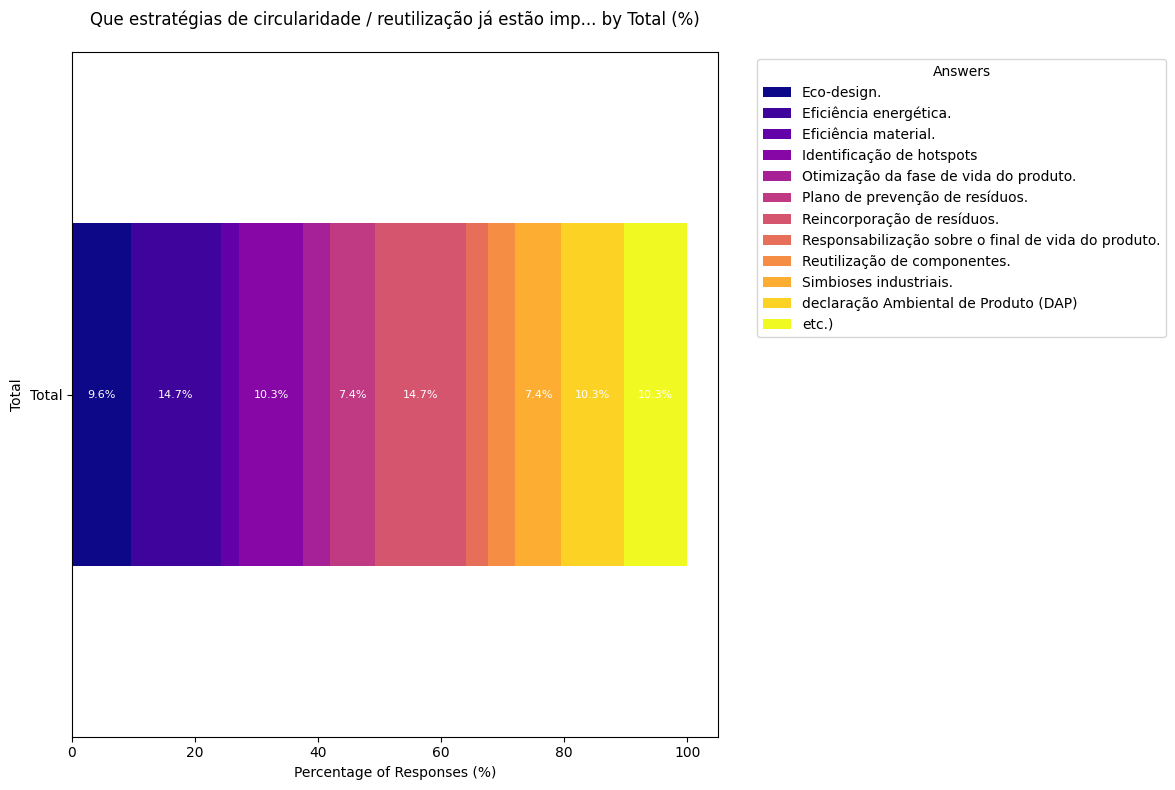

In [85]:

# For location grouping
plot_stacked_percentages(
    target_question='Que estratégias de circularidade / reutilização já estão implementadas na sua entidade?  (É possível selecionar mais do que uma opção).',
    group_by='Total',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

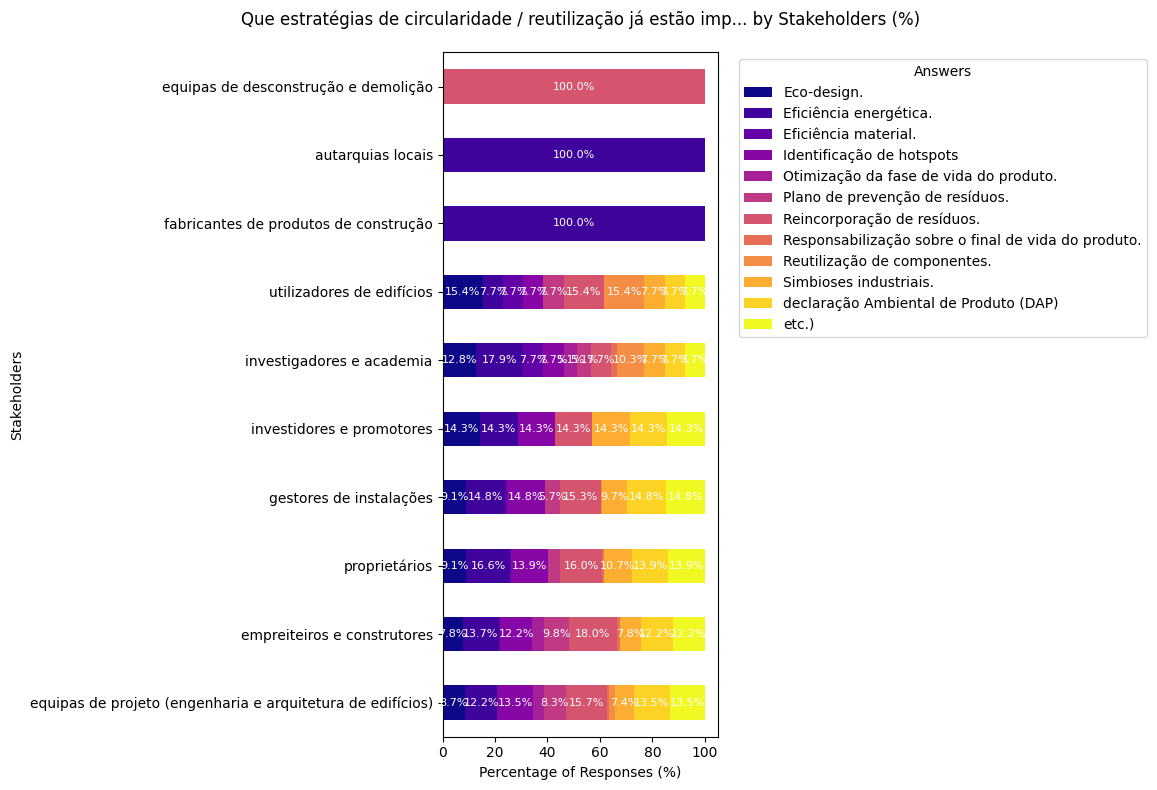

In [92]:
# For location grouping
plot_stacked_percentages(
    target_question='Que estratégias de circularidade / reutilização já estão implementadas na sua entidade?  (É possível selecionar mais do que uma opção).',
    group_by='Stakeholders',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

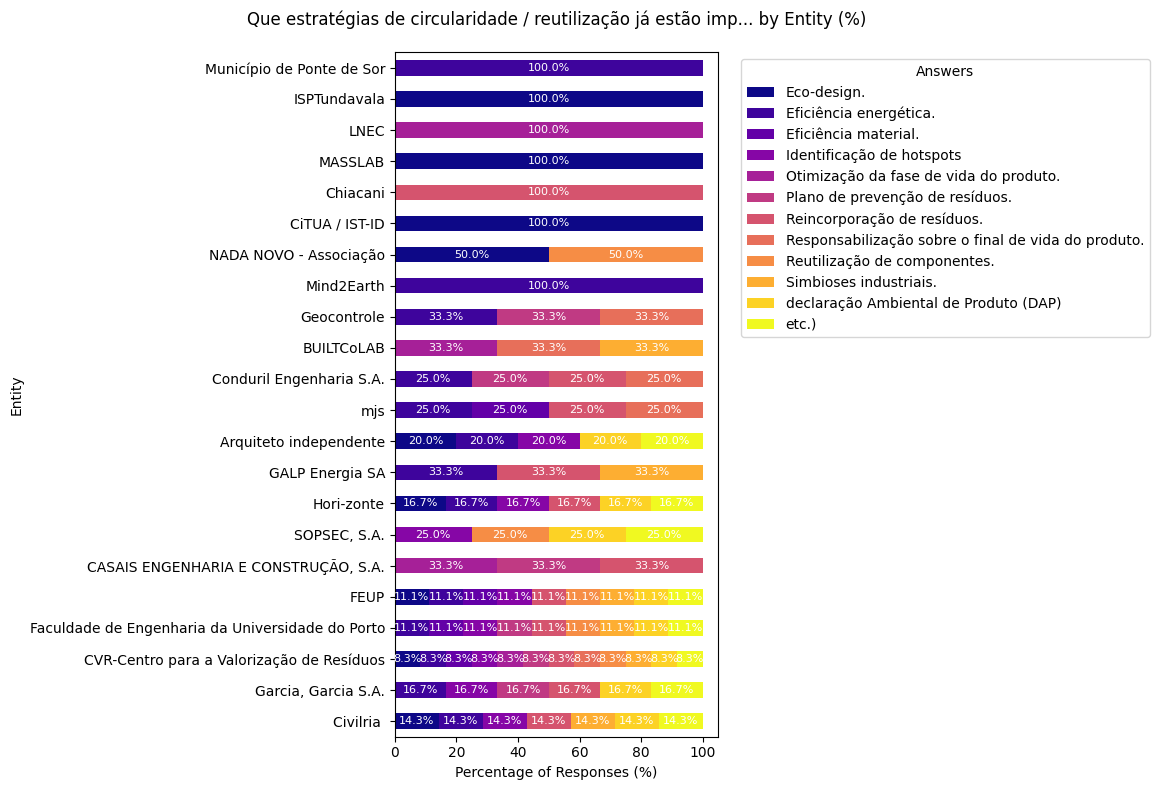

In [93]:
# For location grouping
plot_stacked_percentages(
    target_question='Que estratégias de circularidade / reutilização já estão implementadas na sua entidade?  (É possível selecionar mais do que uma opção).',
    group_by='Entity',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

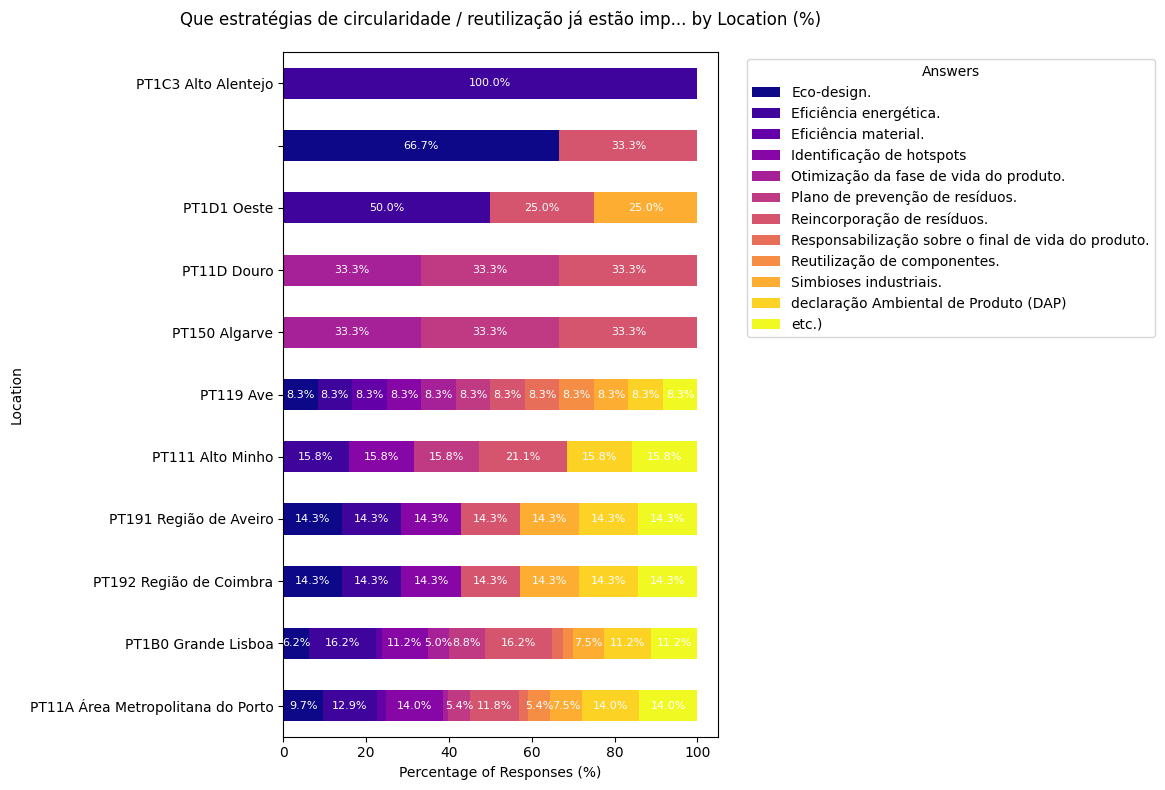

In [94]:
# For location grouping
plot_stacked_percentages(
    target_question='Que estratégias de circularidade / reutilização já estão implementadas na sua entidade?  (É possível selecionar mais do que uma opção).',
    group_by='Location',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

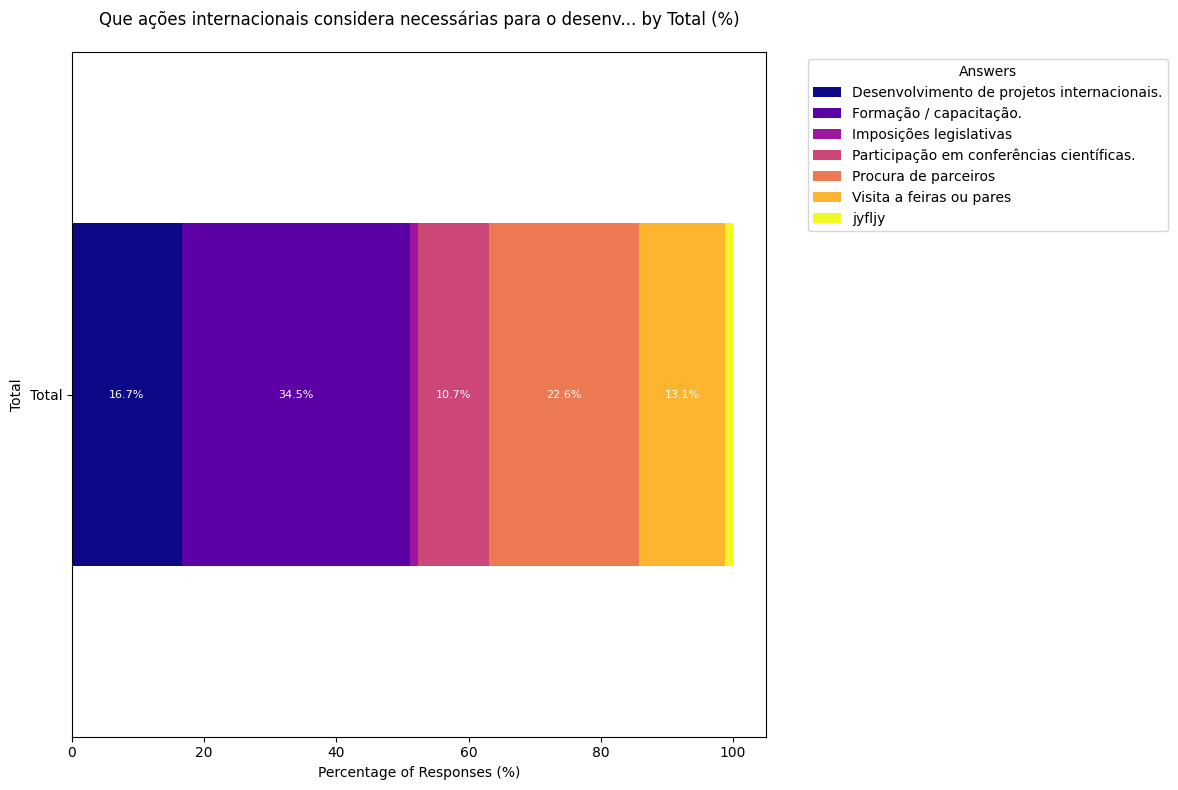

In [95]:

# For location grouping
plot_stacked_percentages(
    target_question='Que ações internacionais considera necessárias para o desenvolvimento de práticas mais circulares / reutilização? (É possível selecionar mais do que uma opção).',
    group_by='Total',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

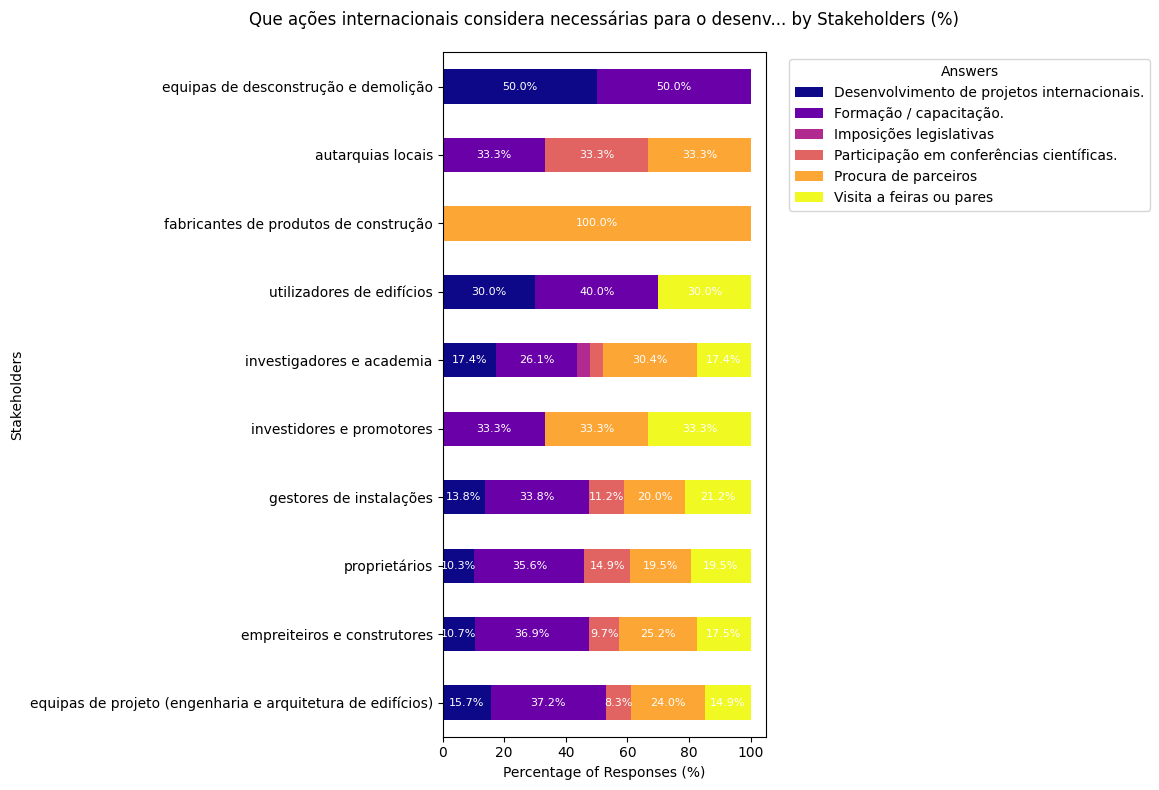

In [96]:
# For location grouping
plot_stacked_percentages(
    target_question='Que ações internacionais considera necessárias para o desenvolvimento de práticas mais circulares / reutilização? (É possível selecionar mais do que uma opção).',
    group_by='Stakeholders',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

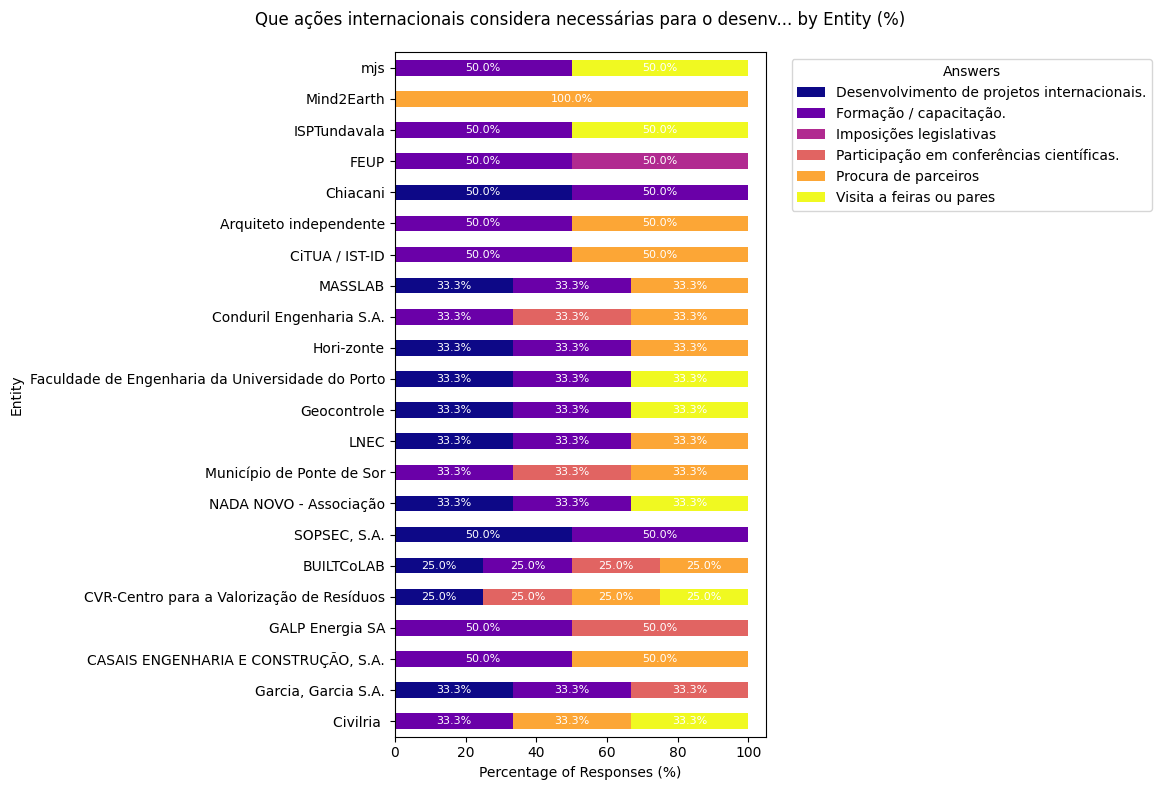

In [97]:
# For location grouping
plot_stacked_percentages(
    target_question='Que ações internacionais considera necessárias para o desenvolvimento de práticas mais circulares / reutilização? (É possível selecionar mais do que uma opção).',
    group_by='Entity',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

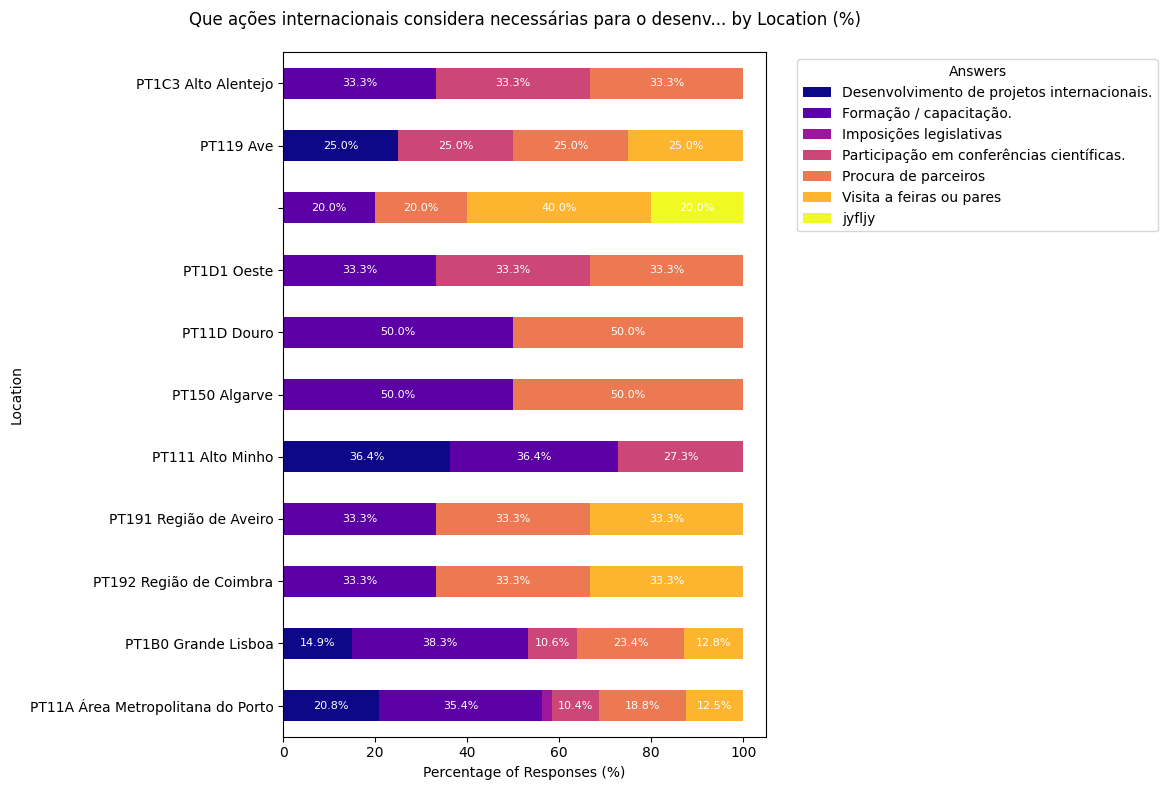

In [98]:
# For location grouping
plot_stacked_percentages(
    target_question='Que ações internacionais considera necessárias para o desenvolvimento de práticas mais circulares / reutilização? (É possível selecionar mais do que uma opção).',
    group_by='Location',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:84: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

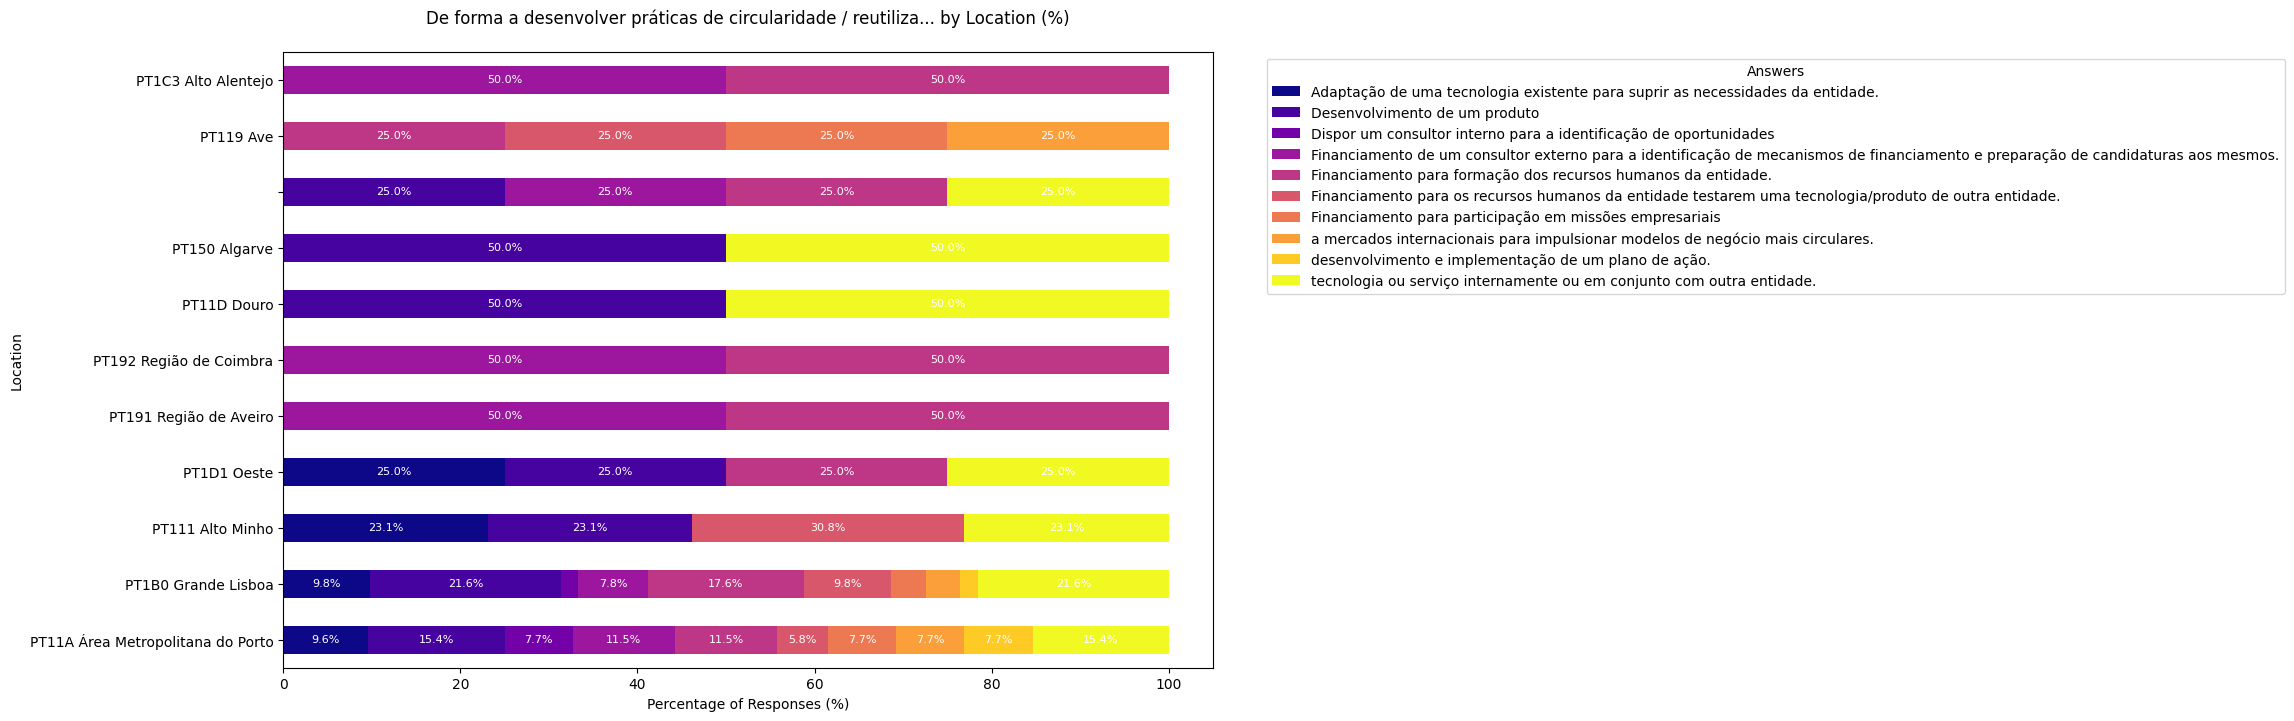

In [103]:

# For location grouping
plot_stacked_percentages(
    target_question='De forma a desenvolver práticas de circularidade / reutilização na sua entidade, em quais das seguintes opções estaria interessado? (É possível selecionar mais do que uma opção).',
    group_by='Location',
    title_suffix='(%)',
    palette='plasma'
)

<Figure size 1200x800 with 0 Axes>

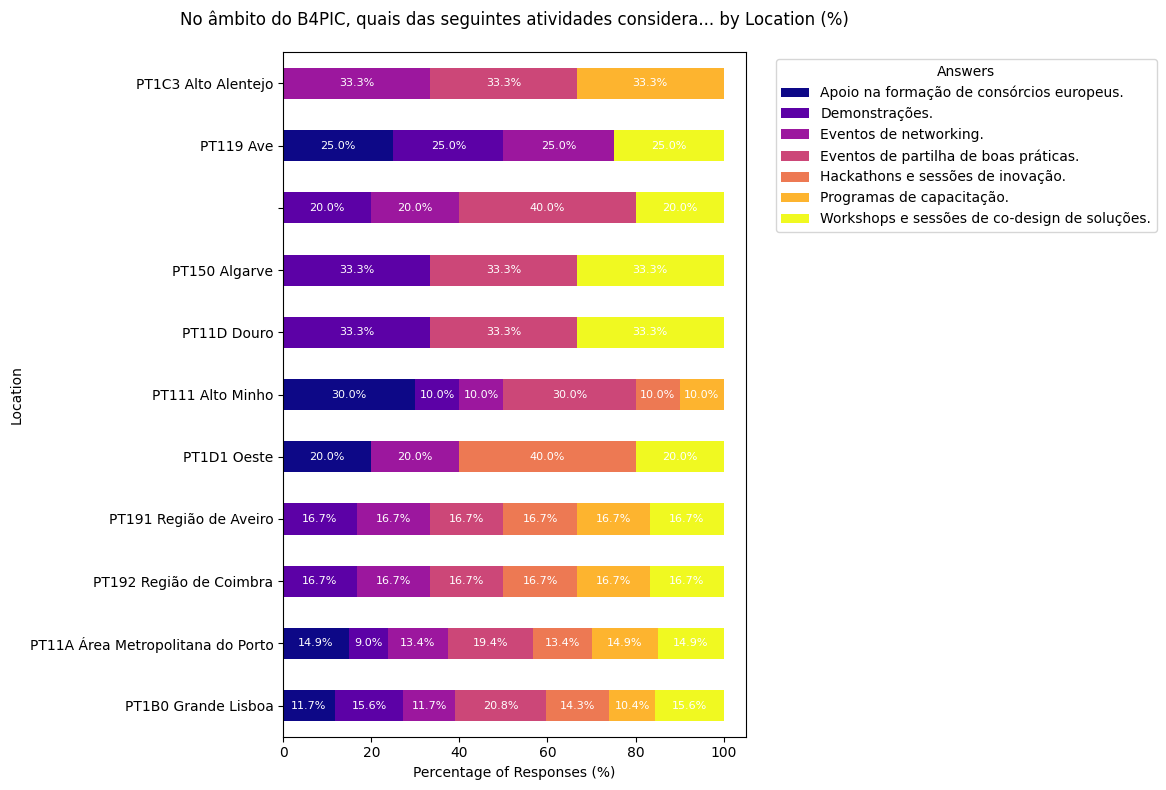

In [107]:
#No âmbito do B4PIC, quais das seguintes atividades considera ser mais importante para a sua organização? (É possível selecionar mais do que uma opção).
# For location grouping
plot_stacked_percentages(
    target_question='No âmbito do B4PIC, quais das seguintes atividades considera ser mais importante para a sua organização? (É possível selecionar mais do que uma opção).',
    group_by='Location',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

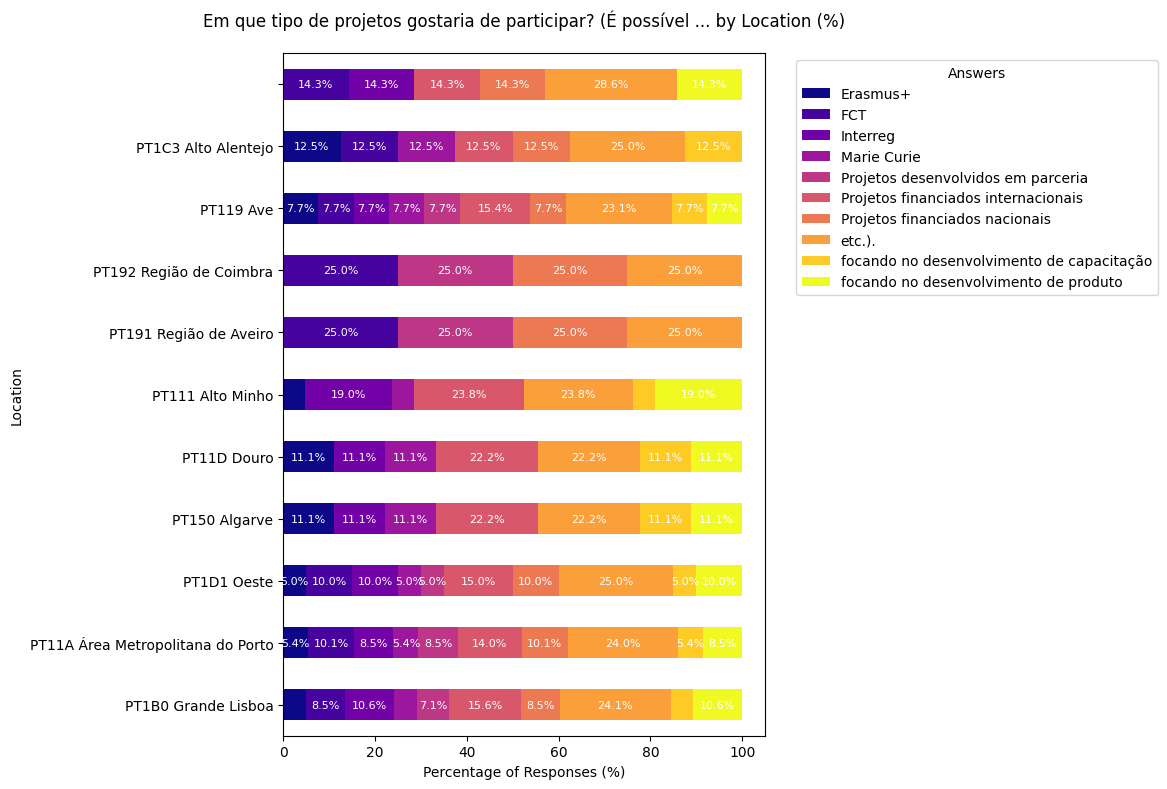

In [111]:

# For location grouping
plot_stacked_percentages(
    target_question='Em que tipo de projetos gostaria de participar? (É possível selecionar mais do que uma opção).',
    group_by='Location',
    title_suffix='(%)',
    palette='plasma'
)

C:\Users\gonca\AppData\Local\Temp\ipykernel_34676\3222123212.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  base_df['Answer'].iloc[i] = base_df['Answer'].iloc[i].split('(exemplo:')[0].strip()


<Figure size 1200x800 with 0 Axes>

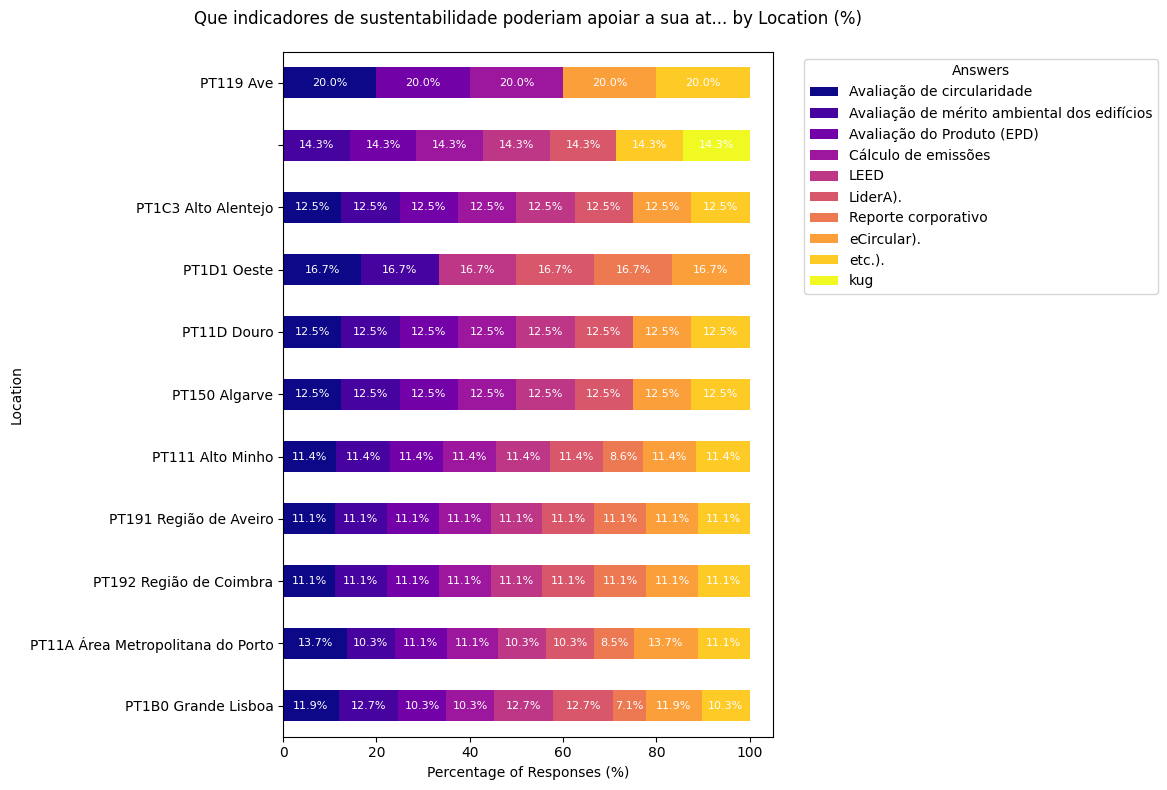

In [115]:
#
# For location grouping
plot_stacked_percentages(
    target_question='Que indicadores de sustentabilidade poderiam apoiar a sua atividade? (É possível selecionar mais do que uma opção).',
    group_by='Location',
    title_suffix='(%)',
    palette='plasma'
)

In [116]:
tidy_df

,Nome da Entidade,Localização NUT III (pode ser selecionada mais do que uma),Answer,Question
1,Faculdade de Engenharia da Universidade do Porto,PT11A Área Metropolitana do Porto,utilizadores de edifícios,Grupo de stakeholders que pertencem à organiza...
2,Faculdade de Engenharia da Universidade do Porto,PT11A Área Metropolitana do Porto,gestores de instalações,Grupo de stakeholders que pertencem à organiza...
3,Faculdade de Engenharia da Universidade do Porto,PT11A Área Metropolitana do Porto,investigadores e academia,Grupo de stakeholders que pertencem à organiza...
4,Conduril Engenharia S.A.,PT11A Área Metropolitana do Porto,empreiteiros e construtores,Grupo de stakeholders que pertencem à organiza...
5,Município de Ponte de Sor,PT1C3 Alto Alentejo,autarquias locais,Grupo de stakeholders que pertencem à organiza...
...,...,...,...,...
1120,CVR-Centro para a Valorização de Resíduos,PT119 Ave,Avaliação do Produto (EPD),Que indicadores de sustentabilidade poderiam a...
1121,CVR-Centro para a Valorização de Resíduos,PT119 Ave,etc.).,Que indicadores de sustentabilidade poderiam a...
1122,BUILTCoLAB,PT11A Área Metropolitana do Porto,Reporte corporativo (exemplo: CSRD).,Que indicadores de sustentabilidade poderiam a...
1123,BUILTCoLAB,PT11A Área Metropolitana do Porto,Avaliação de circularidade (exemplo: Circulytics,Que indicadores de sustentabilidade poderiam a...
